## Cumulative Entropy and Mutual Information


Reference: Journal of Statistical Planning and Inference 12/2009; 139:4072-4087.

In [1]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
random.seed(4408765) 
#import rpy2.robjects as robjects
#import rpy2.robjects.lib.ggplot2 as ggplot2
#%load_ext rpy2.ipython
%load_ext Cython

In [2]:
def xy_cor(N, rho, truncate=True):
    "This function generates two N-element Gaussian random vectors with correlation rho"
    xx = np.array([0, 1])
    yy = np.array([0, 1])
    means = [0, 1]  
    stds = [0.5, 0.5]
    covs = [[stds[0]**2, stds[0]*stds[1]*rho], 
        [stds[0]*stds[1]*rho, stds[1]**2]] 
    m = np.random.multivariate_normal(means, covs, N).T
    x = (m[0] - np.mean(m[0]))/np.std(m[0])
    y = (m[1] - np.mean(m[1]))/np.std(m[1])
    if (truncate == True):
        x = (x - np.min(x))/(np.max(x) - np.min(x))
        y = (y - np.min(y))/(np.max(y) - np.min(y))
        #thres = 3
        #for i in range(N):
        #    if x[i] > thres:
        #        x[i] = thres
        #    if x[i] < -thres:
        #        x[i] = -thres
        #    if y[i] > thres:
        #        y[i] = thres
        #    if y[i] < -thres:
         #       y[i] = -thres  
    return (x, y)

### Define Cumulative Mutual Information Function

In [3]:
# %%cython --annotate

def CMI(x, y):
    "This function computes the Cumulative Mutual Information"
    N = len(x)
    lattice_x = np.zeros((N, N), dtype="float_")    # Array of lower x tile coordinates
    lattice_y = np.zeros((N, N), dtype="float_")     # Array of lower y tile coordinates
    lattice_area = np.zeros((N, N), dtype="float_")   # Array of tile areas
    lattice_count = np.zeros((N, N), dtype="uint8")    # Array of tile data counts
    x_order = np.argsort(x, kind='quicksort')
    x_sorted = x[x_order]
    y_order = np.argsort(y, kind='quicksort')
    y_sorted = y[y_order]
    ind = np.arange(0, N, 1)
    ind_x_order = np.argsort(x_order, kind='quicksort') 
    ind_x = ind[ind_x_order]
    ind_y_order = np.argsort(y_order, kind='quicksort') 
    ind_y = ind[ind_y_order]
    for i in range(N):
        for j in range(N):
            lattice_x[i, j] = x_sorted[i]
            lattice_y[i, j] = y_sorted[j]
            if i < (N-1) and j < (N-1):
                lattice_area[i, j] = (x_sorted[i+1] - x_sorted[i])*(y_sorted[j+1] - y_sorted[j])
        
    for i in range(N): 
        lattice_count[ind_x[i], ind_y[i]] = 1 

    np.cumsum(lattice_count, axis=1, out=lattice_count)
    np.cumsum(lattice_count, axis=0, out=lattice_count)
    CDF_xy = lattice_count/float(N)
    CDF_x = np.arange(0, N, 1)/float(N)
    CDF_y = CDF_x
    CE_x = 0
    CE_y = 0
    for i in range(N-1):
        if CDF_x[i] != 0:
            CE_x = CE_x - (x_sorted[i+1] - x_sorted[i]) * CDF_x[i] * math.log(CDF_x[i])
        if CDF_y[i] != 0:       
            CE_y = CE_y - (y_sorted[i+1] - y_sorted[i]) * CDF_y[i] * math.log(CDF_y[i])

    CE_xy = 0
    for i in range(N):
        for j in range(N):
            if CDF_xy[i, j] != 0:
                CE_xy = CE_xy - lattice_area[i, j] * CDF_xy[i, j] * math.log(CDF_xy[i, j])
             
    # Compute the CMI based on the difference between joint and marginals CE's        
            
    CMI = CE_xy - (max(y) - np.mean(y))*CE_x - (max(x) - np.mean(x))*CE_y  
    if CMI < 0:
        CMI = 0
    
    # Compute the CMI based on the ratio of joint and marginals CE's
    
#    CMI2 = 0
#    for i in range(N):
#        for j in range(N):
#            if CDF_x[i] != 0 and CDF_y[j] != 0 and CDF_xy[i, j] != 0:
#                CMI2 = CMI2 - lattice_area[i, j] * CDF_xy[i, j] * math.log(CDF_xy[i, j])/(CDF_x[i]*CDF_y[j])
        
#    return (CMI, CMI2)
    return (CMI)

### Generate data

In [8]:
N = 100           # Number of x and y data points
inst = 10

corrs = np.arange(0, 1.005, 0.05)
T = len(corrs)
CMI_aver_diff = np.zeros((T), dtype="float_") 
CMI_aver_ratio = np.zeros((T), dtype="float_") 

for t in range(T):
    print(t)
    CMI_diff = np.zeros(inst, dtype="float_") 
    CMI_ratio = np.zeros(inst, dtype="float_") 
    for k in range(inst):
        (x, y) = xy_cor(N, corrs[t], truncate=False)        
        (CMI_diff[k]) = CMI(x, y)        
  
    CMI_aver_diff[t] = np.mean(CMI_diff)
    CMI_aver_ratio[t] = np.mean(CMI_ratio)

/Applications/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: covariance is not positive-semidefinite.


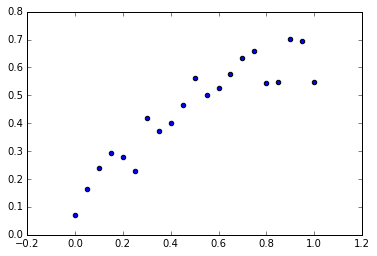

In [9]:
plt.scatter(corrs, CMI_aver_diff)

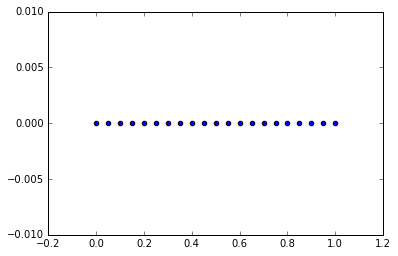

In [10]:
plt.scatter(corrs, CMI_aver_ratio)

In [12]:
(x, y) = xy_cor(N, 0.80)
print(CMI(x, y, False))
(x, y) = xy_cor(N, 0.80)
print(CMI(x, y, False))
(x, y) = xy_cor(N, 0.80)
print(CMI(x, y, False))

TypeError: CMI() takes 2 positional arguments but 3 were given

In [102]:
x = np.random.uniform(low=0.0, high=1.0, size=N)
y = np.random.uniform(low=0.0, high=1.0, size=N)
print(CMI(x, x, False))

0.247267274853
0.247267274853
0.278961104385
(0.030604803817837214, 4.1300995260403317)


In [13]:
x = np.random.uniform(low=0.0, high=1.0, size=200)
y = np.random.uniform(low=0.0, high=1.0, size=200)
start_time = time.time()

for i in range(100):
    z = CMI(x, y)

end_time = time.time() 
print("Execution time %s seconds. " % (end_time - start_time))

Execution time 9.162075996398926 seconds. 


In [15]:
from library.support import *
from library.visualize import *
from library.information import *
from library.ccba import *

In [16]:
start_time = time.time()

for i in range(100):
    z = compute_information_coefficient(x, y)

end_time = time.time() 
print("Execution time %s seconds. " % (end_time - start_time))

Execution time 2.733725070953369 seconds. 
